In [25]:
# import the necessary packages
import os
import pathlib
from re import I
from imutils import paths
import numpy as np
import pickle
import cv2 as cv2
from matplotlib import pyplot as plt

# Vector and homography transforms img2 into img1
# TimeStamp is for img1
class transform():
    def __init__(self, homography, timeStamp, image1_index=float('inf'), image2_index=float('inf')):
        self.homography = homography
        self.timeStamp = timeStamp
        self.image1_index = image1_index
        self.image2_index = image2_index

# Stores data cube into a 3 dimensional array with images being stored on the yz axis and each x layer representing a wavelength
# z query's the linescans
def readDataCube(filePath):
    lines = []
    with open(filePath) as f:
        lines = f.readlines()
        f.close()
        dataCube = []
        for line in lines:
            row = []
            for element in line.split("\t"):
                row.append(float(element))
            dataCube.append(row)

    np_data_cube=np.asarray(dataCube)

    # This loadedArr is a 2D array, therefore
    # we need to convert it to the original
    # array shape.reshaping to get original
    # matrice with original shape.`
    dimA=np.shape(np_data_cube)[0]          # 341 or #of wavelength buckets
    dimB=int(np.shape(np_data_cube)[1]/200) # height of scan? <- has to be I think
    dimC=200                                # len of scan

    cube_file=np.zeros(shape=(dimA,dimB,dimC),dtype=int)
    cube_file=np.reshape(np_data_cube,(dimA,dimB,dimC))
    return cube_file

# Warps img1 to the position of img2
def transformWarping2To1(img1, img2):
    timestamp = img1[1]
    img1 = img1[0]
    img2 = img2[0]
    ### CALCULATE MATCHING KEY POINTS BETWEEN IMAGES ###
    MIN_MATCH_COUNT = 10
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    ### CALCULATE HOMOGRAPHY BETWEEN IMAGES ###
    homography = None
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return None
    if homography is None:
        return None
    return transform(homography, timestamp)

# findClosestTransform does a binary search through transforms to find closest match search_time
# NOTE: search_time MUST have the form HH_MM_SS_FFFFFF if it has fewer characters the conversion will fail
def findClosestTransform(search_time, transforms):
    indexL = 0
    indexC = len(transforms)//2
    indexR = len(transforms)-1
    considered_transform = transforms[indexC]
    while indexL < indexR:
        #print(f"L={indexL} C={indexC} R={indexR} tran={considered_transform.timeStamp}")
        if int(search_time) < int(considered_transform.timeStamp): # string to find is on the left of considered_transform
            indexR = indexC-1
            indexC = indexL+((indexR - indexL)//2)
            indexL = indexL
        elif int(search_time) > int(considered_transform.timeStamp): # string to find is on the right of considered_transform
            indexL = indexC+1
            indexC = indexL+((indexR - indexL)//2)
            indexR = indexR
        elif int(search_time) == int(considered_transform.timeStamp):
            return considered_transform
        considered_transform = transforms[indexC]
    return considered_transform

# findClosestTransform does a binary search through transforms to find closest match search_time
# NOTE: search_time MUST have the form HH_MM_SS_FFFFFF if it has fewer characters the conversion will fail
def findClosestImage(search_time, images):
    indexL = 0
    indexC = len(images)//2
    indexR = len(images)-1
    considered_image = images[indexC]
    while indexL < indexR:
        #print(f"L={indexL} C={indexC} R={indexR} tran={considered_image[1]}")
        if int(search_time) < int(considered_image[1]): # string to find is on the left of considered_transform
            indexR = indexC-1
            indexC = indexL+((indexR - indexL)//2)
            indexL = indexL
        elif int(search_time) > int(considered_image[1]): # string to find is on the right of considered_transform
            indexL = indexC+1
            indexC = indexL+((indexR - indexL)//2)
            indexR = indexR
        elif int(search_time) == int(considered_image[1]):
            return (indexC, considered_image)
        considered_image = images[indexC]
    return (indexC, considered_image)

# Returns a transform warping the linescan at linescan_time2 into the linescan at linescan_time1
# Returns None if a match isn't found in under 6 searches
def transformLineScan2To1(linescan_time1, linescan_time2, images):
    match_found = False
    image1_index, image1 = findClosestImage(linescan_time1, images)
    image2_index, image2 = findClosestImage(linescan_time2, images)
    search_breadth = 0
    search_breadth_limit = 5
    for search_breadth in range(search_breadth_limit):
        transform = transformWarping2To1(images[image1_index+search_breadth], images[image2_index])
        if transform is not None:
            transform.image1_index = image1_index+search_breadth
            transform.image2_index = image2_index
            return transform
        transform = transformWarping2To1(images[image1_index-search_breadth], images[image2_index])
        if transform is not None:
            transform.image1_index = image1_index-search_breadth
            transform.image2_index = image2_index
            return transform
        transform = transformWarping2To1(images[image1_index], images[image2_index+search_breadth])
        if transform is not None:
            transform.image1_index = image1_index
            transform.image2_index = image2_index+search_breadth
            return transform
        transform = transformWarping2To1(images[image1_index], images[image2_index-search_breadth])
        if transform is not None:
            transform.image1_index = image1_index
            transform.image2_index = image2_index-search_breadth
            return transform
    print(f"[ERROR] Possible bad matching in transformLineScan2To1, search_breadth over {search_breadth_limit}")
    return None

In [26]:
### GET ALL IMAGES FROM PATH AND APPEND TO IMAGES ###
path = pathlib.Path(os.path.abspath(''))
path = os.path.join(path, "imageWriteDir/recordingAt16_05_31_057077/")
print("[INFO] Loading images from: ", path)
imagePaths = sorted(list(paths.list_images(path)))
images = []
for imagePath in imagePaths:
    timestamp = os.path.basename(os.path.normpath(imagePath))[0:-4] # strips the .png ending off the string
    image = cv2.imread(imagePath, 0) # grayscale specified
    images.append((image, timestamp))
print("[INFO] Images loaded")

cube_file = readDataCube('..\\data\\TwoWhitePaperOnGround.cube') # [spectrum, linescan points, linescan]
ff = open('.tempTime\\timestamps_16_12_53.pick',"rb")
line_scan_times = pickle.load(ff)
if len(line_scan_times) != len(cube_file[0,:,0]):
    print("[ERROR] LineScan times different from cube file length")

[INFO] Loading images from:  c:\Users\gabri\OneDrive\Desktop\BiiMLab\biim-lab-hyperspectral\Src\imageWriteDir/recordingAt16_05_31_057077/
[INFO] Images loaded
[ERROR] LineScan times different from cube file length


In [31]:
FINAL_IMAGE_X_LENGTH = 100
FINAL_IMAGE_Y_LENGTH = 1000
NUMBER_OF_WAVELENGTH_SLICES = 341
WAVELENGTH = 130
LINE_SCAN_LENGTH = len(cube_file[0])
IMAGE_Y_LENGTH = len(images[0])
IMAGE_X_LENGTH = len(images[0][0])
OFFSET_X = 50
OFFSET_Y = 50

picture_manual_dst = np.zeros((FINAL_IMAGE_Y_LENGTH, FINAL_IMAGE_X_LENGTH))
#picture_manual_dst[0:, len(img1[0][0])//2] = img1[:][len(img1[0][0])//2]
fail_count = 0
accumulated_homography = np.identity(3)
previous_timestamp_transform = transform(np.identity(3), 0)
timestamp_transform = transform(np.identity(3), 0)
base_timestamp_index = 0
timestamp_index = 1
while timestamp_index < len(line_scan_times[1:]):
  previous_timestamp_transform = timestamp_transform
  timestamp_transform = transformLineScan2To1(line_scan_times[base_timestamp_index], line_scan_times[timestamp_index], images)
  if timestamp_transform is None:
    fail_count += 1
    base_timestamp_index = timestamp_index-1
    accumulated_homography = np.matmul(accumulated_homography, previous_timestamp_transform.homography)
  else:
    for vertical_pixel_index in range(IMAGE_Y_LENGTH):
      for horizontal_pixel_index in range(20):
        x = IMAGE_X_LENGTH//2-10+horizontal_pixel_index
        y = vertical_pixel_index
        src = np.array([[x, y]], dtype='float32')
        src = np.array([src])
        current_homography = np.matmul(accumulated_homography, timestamp_transform.homography)
        dst = cv2.perspectiveTransform(src, current_homography)
        place_x = int(max(0, min(dst[0][0][0], len(picture_manual_dst[0])-1)))
        place_y = int(max(0, min(dst[0][0][1], len(picture_manual_dst)-1)))
        picture_manual_dst[place_y][place_x] = images[timestamp_transform.image2_index][0][y][x]
    timestamp_index += 1

print(f"[INFO] failure count is {fail_count}")
plt.imshow(picture_manual_dst),plt.show()

Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 4/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 9/10
Not enough matches are found - 10/10
Not enough matches are found - 10/10
Not enough matches are found - 9/10
Not enough matches are found - 9/10
Not enough matches are found - 9/10
Not enough matches are found - 9/10
Not enough matches are found - 7/10
Not enough matches are found - 9/10
Not enough matches are found - 9/10
Not enough matches are found - 6/10
Not enough matches are found - 7/10
Not enough matches are found - 0/10
Not enough ma

AttributeError: 'NoneType' object has no attribute 'homography'

trans length 200


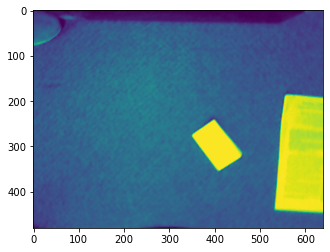

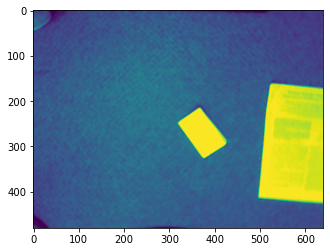

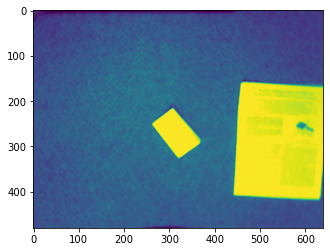

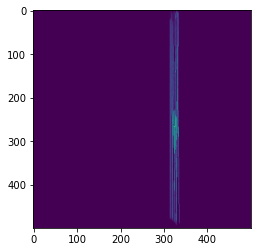

(<matplotlib.image.AxesImage at 0x18dcc25f070>, None)

In [ ]:
accumulated_homography = np.identity(3)
picture_manual_dst = np.zeros((500, 500))
#picture_manual_dst[0:, len(img1[0][0])//2] = img1[:][len(img1[0][0])//2]

for timestamp_index, line_scan_time in enumerate(line_scan_times):
  accumulated_homography = np.matmul(accumulated_homography, a_transform.homography)
  for horizontal_pixel_index in range(len(img1[0])):
    x = len(img1[0][0])//2
    y = horizontal_pixel_index
    src = np.array([[x, y]], dtype='float32')
    src = np.array([src])
    dst = cv2.perspectiveTransform(src, accumulated_homography)
    place_x = int(max(0, min(dst[0][0][0], len(picture_manual_dst[0])-1)))
    place_y = int(max(0, min(dst[0][0][1], len(picture_manual_dst)-1)))
    picture_manual_dst[place_y][place_x] = images[a_transform.img2_index][0][y][x]

plt.imshow(picture_manual_dst),plt.show()

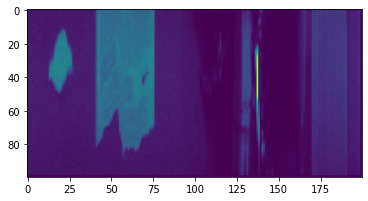

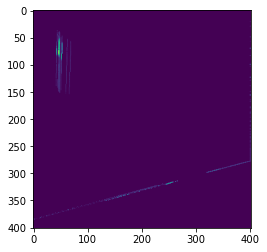

(<matplotlib.image.AxesImage at 0x18dcc3e04c0>, None)

In [ ]:
wavelen = 130
plt.imshow(cube_file[wavelen]),plt.show()
horizontal_dimension = 400
vertical_dimension = 400
number_of_wavelen_slices = 341
LINE_SCAN_LENGTH = len(cube_file[0])
IMAGE_X_LENGTH = len(images[0])
IMAGE_Y_LENGTH = len(images[0][0])
OFFSET_X = 50
OFFSET_Y = 50

accumulated_homography = np.identity(3)
hyperCube = np.zeros((number_of_wavelen_slices,vertical_dimension+1,horizontal_dimension+1)) #TODO: [there are 341 wavelen slices, ,]
for linescan_index in range(len(cube_file[0][0])): # for each linescan
    accumulated_homography = np.matmul(accumulated_homography, line_scan_transforms[linescan_index].homography)
    for point_index in range(len(cube_file[wavelen])): # for each point in each linescan
        # perform point shift
        x = IMAGE_X_LENGTH//2
        # Use simple interpolation to match the number of pixels in a lines scan to the number of pixels in each photograph
        scale_factor = IMAGE_Y_LENGTH/LINE_SCAN_LENGTH
        scale_factor = 1
        y = point_index*scale_factor
        if linescan_index<len(line_scan_transforms):
            src = np.array([[x, y]], dtype='float32')
            src = np.array([src])
            [[[point_x, point_y]]] = cv2.perspectiveTransform(src, accumulated_homography)
            point_x += OFFSET_X
            point_y += OFFSET_Y
        else: # The actual image is longer than the number of transforms we have so we put the extra pixels in the 0,0 pixel.
            point_x = 0
            point_y = 0
        #print((point_x, point_y))
        point_x = max(0, min(horizontal_dimension-1, point_x))
        point_y = max(0, min(vertical_dimension-1, point_y))
        hyperCube[wavelen, int(point_y), int(point_x)] = cube_file[wavelen][point_index][linescan_index]

        '''
        for j in range(-2, 1):
            for k in range(-2, 1):
                hyperCube[wavelen, max(0, min(vertical_dimension, int(point_y)+k)), max(0, min(horizontal_dimension, int(point_x)+j))] = cube_file[wavelen][point_index][linescan_index]
        '''

plt.imshow(hyperCube[wavelen]),plt.show()
